# Accurate sgRNA/identity-barcode assignment with scAR

## --- Feature barcode Denoising for scCRISPRseq (inc. CROP-seq, Perturb-seq, CRISP-seq) or cell indexing experiments

In this tutorial, we'll be walking through the steps to accurate assignment of sgRNAs/identity-barcodes. In this experiment, A549 lung carcinoma cells were transduced with a pool containing 93 total sgRNAs (90 sgRNAs targeting 45 different genes and 3 control sgRNAs). Cells were split into 6 conditions, receiving no treatment or treatments of DZNep, Trichostatin A, Valproic Acid, Kinetin, or, Resveratrol. Before sequencing, cells were multiplexed at equal proportions with 1 CMO per sample type. The original dataset is downloaded from 10x genomics [dataset](https://www.10xgenomics.com/resources/datasets/30-k-a-549-lung-carcinoma-cells-treatments-transduced-with-a-crispr-pool-multiplexed-6-cm-os-3-1-standard-6-0-0), and metadata is available at [scAR-reproducibility/data](https://github.com/CaibinSh/scAR-reproducibility/tree/main/data)  
  
  - Run on your own device. You need to install several packages, [Scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) and [scAR](https://github.com/CaibinSh/scAR/blob/main/README.md)
  - Run on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CaibinSh/scAR-reproducibility/blob/main/reproducibility/scAR_tutorial_sgRNA_assignment.ipynb) **This option does not work at the moment, we will fix it soon**

In [ ]:
# Skip this cell if running on your own device
# Run this cell to install Scanpy and scAR in Colab

!pip install scanpy

!git clone https://github.com/CaibinSh/scAR.git
!pip install scAR/

!git clone https://github.com/CaibinSh/scAR-reproducibility.git
!cd scAR-reproducibility/reproducibility

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import scAR

import warnings
warnings.simplefilter("ignore")

In [2]:
from matplotlib import pylab

params = {'legend.fontsize': 8,
          'figure.facecolor':"w",
          'figure.figsize': (6, 4.5),
         'axes.labelsize': 10,
         'axes.titlesize':10,
         'axes.linewidth': 0.5,
         'xtick.labelsize':8,
         'ytick.labelsize':8,
         'axes.grid':False,}
pylab.rc('font',**{'family':'serif','serif':['Palatino'],'size':10})
pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");

## read data

The filtered count matrices can be downloaded from 10x Dataset. We annotated cells by their cell species and provided the annotation file.

In [3]:
A549_30K = sc.read_10x_h5(filename='../data/CRISPR_A549_30K_Multiplex_count_raw_feature_bc_matrix.h5ad',
                          gex_only=False,
                          backup_url='https://cf.10xgenomics.com/samples/cell-exp/6.0.0/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_count_raw_feature_bc_matrix.h5');
A549_30K.var_names_make_unique();

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Get sgRNA counts and cell tag (here, CMO) counts

In [4]:
A549_30K_sgRNA_raw = A549_30K[:, A549_30K.var['feature_types']=='CRISPR Guide Capture'].to_df()

A549_30K_CMO_raw = A549_30K[:, A549_30K.var['feature_types']=='Multiplexing Capture'].to_df()

kneeplot of mRNA counts to identify cell-free droplets

In [5]:
rank_UMIs = pd.DataFrame(A549_30K[:,A549_30K.var['feature_types']=='Gene Expression'].X.sum(axis=1), index = A549_30K.obs_names, columns=['total_counts'])

rank_UMIs['droplets'] = 'cell-free droplets'
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>10, 'droplet II')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>200, 'droplet I')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>500, 'cells')
rank_UMIs = rank_UMIs.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
rank_UMIs = rank_UMIs.loc[rank_UMIs['total_counts']>0]
rank_UMIs = rank_UMIs.set_index('index').rename_axis('cells')

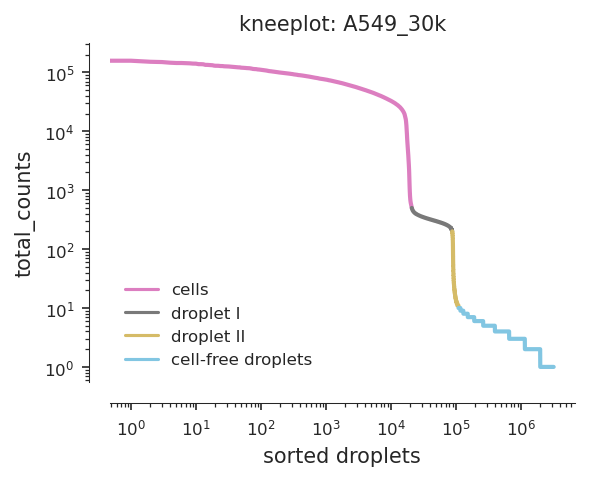

In [6]:
plt.figure(figsize=(4, 3), dpi=150)

ax = sns.lineplot(data = rank_UMIs,
                  x='rank',
                  y='total_counts',
                  hue='droplets',
                  hue_order=['cells', 'droplet I', 'droplet II', 'cell-free droplets'],
                  palette=sns.color_palette()[-4:],
                  markers=False,
                  lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sorted droplets');
ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
ax.set_title(f'kneeplot: A549_30k');

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=10, trim=False);

We then calculate ambient profiles for both sgRNAs and CMOs using cell-free droplets, as the droplet I and II might contain cell debris

## Prepare inputs for scAR.

Raw sgRNA counts and CMO counts in cell-containing droplets

In [7]:
A549_30K_filtered = A549_30K[A549_30K.obs_names.isin(rank_UMIs[rank_UMIs['droplets']=='cells'].index)] # equal to filtered population as cellranger output

A549_30K_sgRNAs_filtered = A549_30K_filtered[:, A549_30K_filtered.var['feature_types']=='CRISPR Guide Capture'].to_df() # pandas.DataFrame
A549_30K_CMO_filtered = A549_30K_filtered[:, A549_30K_filtered.var['feature_types']=='Multiplexing Capture'].to_df() # pandas.DataFrame

Calculate empty profiles for both sgRNAs and CMOs.

In [8]:
empty_droplets_sgRNAs = A549_30K_sgRNA_raw.loc[A549_30K_sgRNA_raw.index.difference(A549_30K_sgRNAs_filtered.index)]
empty_profile_sgRNAs = empty_droplets_sgRNAs.sum()/empty_droplets_sgRNAs.sum().sum()    # pandas.Series

empty_droplets_CMO = A549_30K_CMO_raw.loc[A549_30K_CMO_raw.index.difference(A549_30K_CMO_filtered.index)]
empty_profile_CMO = empty_droplets_CMO.sum()/empty_droplets_CMO.sum().sum() # pandas.Series

## Train scAR

### sgRNA assignment

In [9]:
scarObj = scAR.model(raw_count=A549_30K_sgRNAs_filtered,
                     empty_profile=empty_profile_sgRNAs.values, # In the case of default None, the empty_profile will be calculated by averaging pooled cells
                     scRNAseq_tech='CROPseq')

scarObj.train(epochs=400,
              batch_size=64,)

# After training, we can infer the native true signal
scarObj.inference(feature_type='sgRNAs',
                  cutoff=3,
                 )  # by defaut, batch_size=None, set a batch_size if getting a GPU memory issue

..Running VAE using the following param set:
......scAR mode:  CROPseq
......count model:  binomial
......num_input_feature:  93
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 400/400 [13:14<00:00,  1.99s/it]
  Inferring .....


Resulting assignment is saved in scarObj.feature_assignment, give a quick check.  
If there are multiple guides detected after denoising, try to increase the cutoff and re-run,
> scarObj.inference(feature_type='sgRNAs', cutoff=10)

In [10]:
scarObj.feature_assignment

,sgRNAs,n_sgRNAs
AAACCCAAGCTAAGTA-1,H2AFY-1,1
AAACCCAAGGAAGTGA-1,PPIB-2,1
AAACCCAAGGTTGGAC-1,ACE2-1,1
AAACCCAAGTGCGTCC-1,Non-Targeting-8,1
AAACCCAAGTGCTCGC-1,CTCF-2,1
...,...,...
TTTGTTGTCCCATTTA-1,CSNK2A1-1,1
TTTGTTGTCGGAACTT-1,EIF4EBP1-2,1
TTTGTTGTCGGCTGTG-1,SUZ12-1,1
TTTGTTGTCTGGGCGT-1,GSK3A-2,1


Download metadata of sgRNA libraries

In [11]:
!wget https://cf.10xgenomics.com/samples/cell-exp/6.0.0/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_count_feature_reference.csv

metadata_guide = pd.read_csv('SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_count_feature_reference.csv', sep='\t')

sgRNA2target = dict()
for val in metadata_guide.iloc[11:].values:
    array_txt = val[0].split(",")
    if not array_txt[0].startswith("CMO"):
        sgRNA2target.update({array_txt[0]: array_txt[-1]})

--2022-02-17 13:38:56--  https://cf.10xgenomics.com/samples/cell-exp/6.0.0/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_count_feature_reference.csv
Resolving nibr-proxy.global.nibr.novartis.net (nibr-proxy.global.nibr.novartis.net)... 10.145.44.229
Connecting to nibr-proxy.global.nibr.novartis.net (nibr-proxy.global.nibr.novartis.net)|10.145.44.229|:2011... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10833 (11K) [text/csv]
Saving to: ‘SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_count_feature_reference.csv.8’

100%[======================================>] 10,833      --.-K/s   in 0.1s    

2022-02-17 13:38:57 (72.4 KB/s) - ‘SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_count_feature_reference.csv.8’ saved [10833/10833]



Integration of sgRNA assginment and anndata

In [12]:
scarObj.feature_assignment["target_genes"] = scarObj.feature_assignment["sgRNAs"].map(sgRNA2target)
A549_30K_filtered.obs = A549_30K_filtered.obs.join(scarObj.feature_assignment, how='left')

In [13]:
A549_30K_filtered.obs.head()

,sgRNAs,n_sgRNAs,target_genes
AAACCCAAGCTAAGTA-1,H2AFY-1,1,H2AFY
AAACCCAAGGAAGTGA-1,PPIB-2,1,PPIB
AAACCCAAGGTTGGAC-1,ACE2-1,1,ACE2
AAACCCAAGTGCGTCC-1,Non-Targeting-8,1,NaN
AAACCCAAGTGCTCGC-1,CTCF-2,1,CTCF


### CMO assignment

The cell indexing counts are noisy, so we perform CMO assignment using scAR.

In [14]:
scarObj_CMO = scAR.model(raw_count=A549_30K_CMO_filtered,
                         empty_profile=empty_profile_CMO.values, # In the case of default None, the empty_profile will be calculated by averaging pooled cells
                         scRNAseq_tech='CROPseq')

scarObj_CMO.train(epochs=400,
              batch_size=64,)

# After training, we can infer the native true signal
scarObj_CMO.inference(feature_type='CMO',
                      cutoff=3,
                     )  # by defaut, batch_size=None, set a batch_size if getting a GPU memory issue

..Running VAE using the following param set:
......scAR mode:  CROPseq
......count model:  binomial
......num_input_feature:  12
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 400/400 [14:01<00:00,  2.10s/it]
  Inferring .....


Download metadata of CMOs and treatments

In [15]:
!wget https://cf.10xgenomics.com/samples/cell-exp/6.0.0/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_config.csv

metadata = pd.read_csv('SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_config.csv', sep='\t')

CMO2Tret = dict()
for val in metadata.iloc[11:].values:
    array_txt = val[0].split(",")
    CMO2Tret.update({array_txt[1]: array_txt[2].split("v2_")[-1]})

--2022-02-17 13:53:07--  https://cf.10xgenomics.com/samples/cell-exp/6.0.0/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex/SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_config.csv
Resolving nibr-proxy.global.nibr.novartis.net (nibr-proxy.global.nibr.novartis.net)... 10.145.44.229
Connecting to nibr-proxy.global.nibr.novartis.net (nibr-proxy.global.nibr.novartis.net)|10.145.44.229|:2011... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1360 (1.3K) [text/csv]
Saving to: ‘SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_config.csv.3’

100%[======================================>] 1,360       --.-K/s   in 0s      

2022-02-17 13:53:08 (12.2 MB/s) - ‘SC3_v3_NextGem_DI_CellPlex_CRISPR_A549_30K_Multiplex_config.csv.3’ saved [1360/1360]



In [16]:
CMO2Tret

{'CMO307': 'No_Treatment',
 'CMO308': 'DZNep',
 'CMO309': 'Trichostatin_A',
 'CMO310': 'Valproic_Acid',
 'CMO311': 'Kinetin',
 'CMO312': 'Resveratrol'}

In [23]:
scarObj_CMO.feature_assignment['treatment'] = scarObj_CMO.feature_assignment['CMO'].map(CMO2Tret)
A549_30K_filtered.obs = A549_30K_filtered.obs.join(scarObj_CMO.feature_assignment, how='left')

## Cell clustering

Finally, we can cluster the cells and visulize them with UMAP. 

In [24]:
A549_30K_mRNA_filtered = A549_30K_filtered[:, A549_30K_filtered.var['feature_types']=='Gene Expression']

In [26]:
random_state = 8
adata_out = A549_30K_mRNA_filtered.copy()
sc.pp.filter_genes(adata_out, min_cells=20)
sc.pp.filter_cells(adata_out, min_genes=200)
sc.pp.normalize_total(adata_out, target_sum=1e4)
sc.pp.log1p(adata_out)

sc.tl.pca(adata_out, svd_solver='arpack', random_state=random_state)
sc.pp.neighbors(adata_out, n_neighbors=15, n_pcs=25, random_state=random_state)

sc.tl.leiden(adata_out, key_added='leiden_clusters', resolution=0.5, random_state=random_state)
sc.tl.umap(adata_out, random_state=random_state)

Let's filter out the cells with multiple sgRNAs or CMOs

In [30]:
adata_out = adata_out[(adata_out.obs['n_sgRNAs']==1) & (adata_out.obs['n_CMO']==1)]

In [33]:
print("the ratio of final cells is {:.2f}".format(adata_out.shape[0]/A549_30K_mRNA_filtered.shape[0]))

the ratio of final cells is 0.81


Trying to set attribute `.obs` of view, copying.
... storing 'sgRNAs' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'target_genes' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'CMO' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'treatment' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


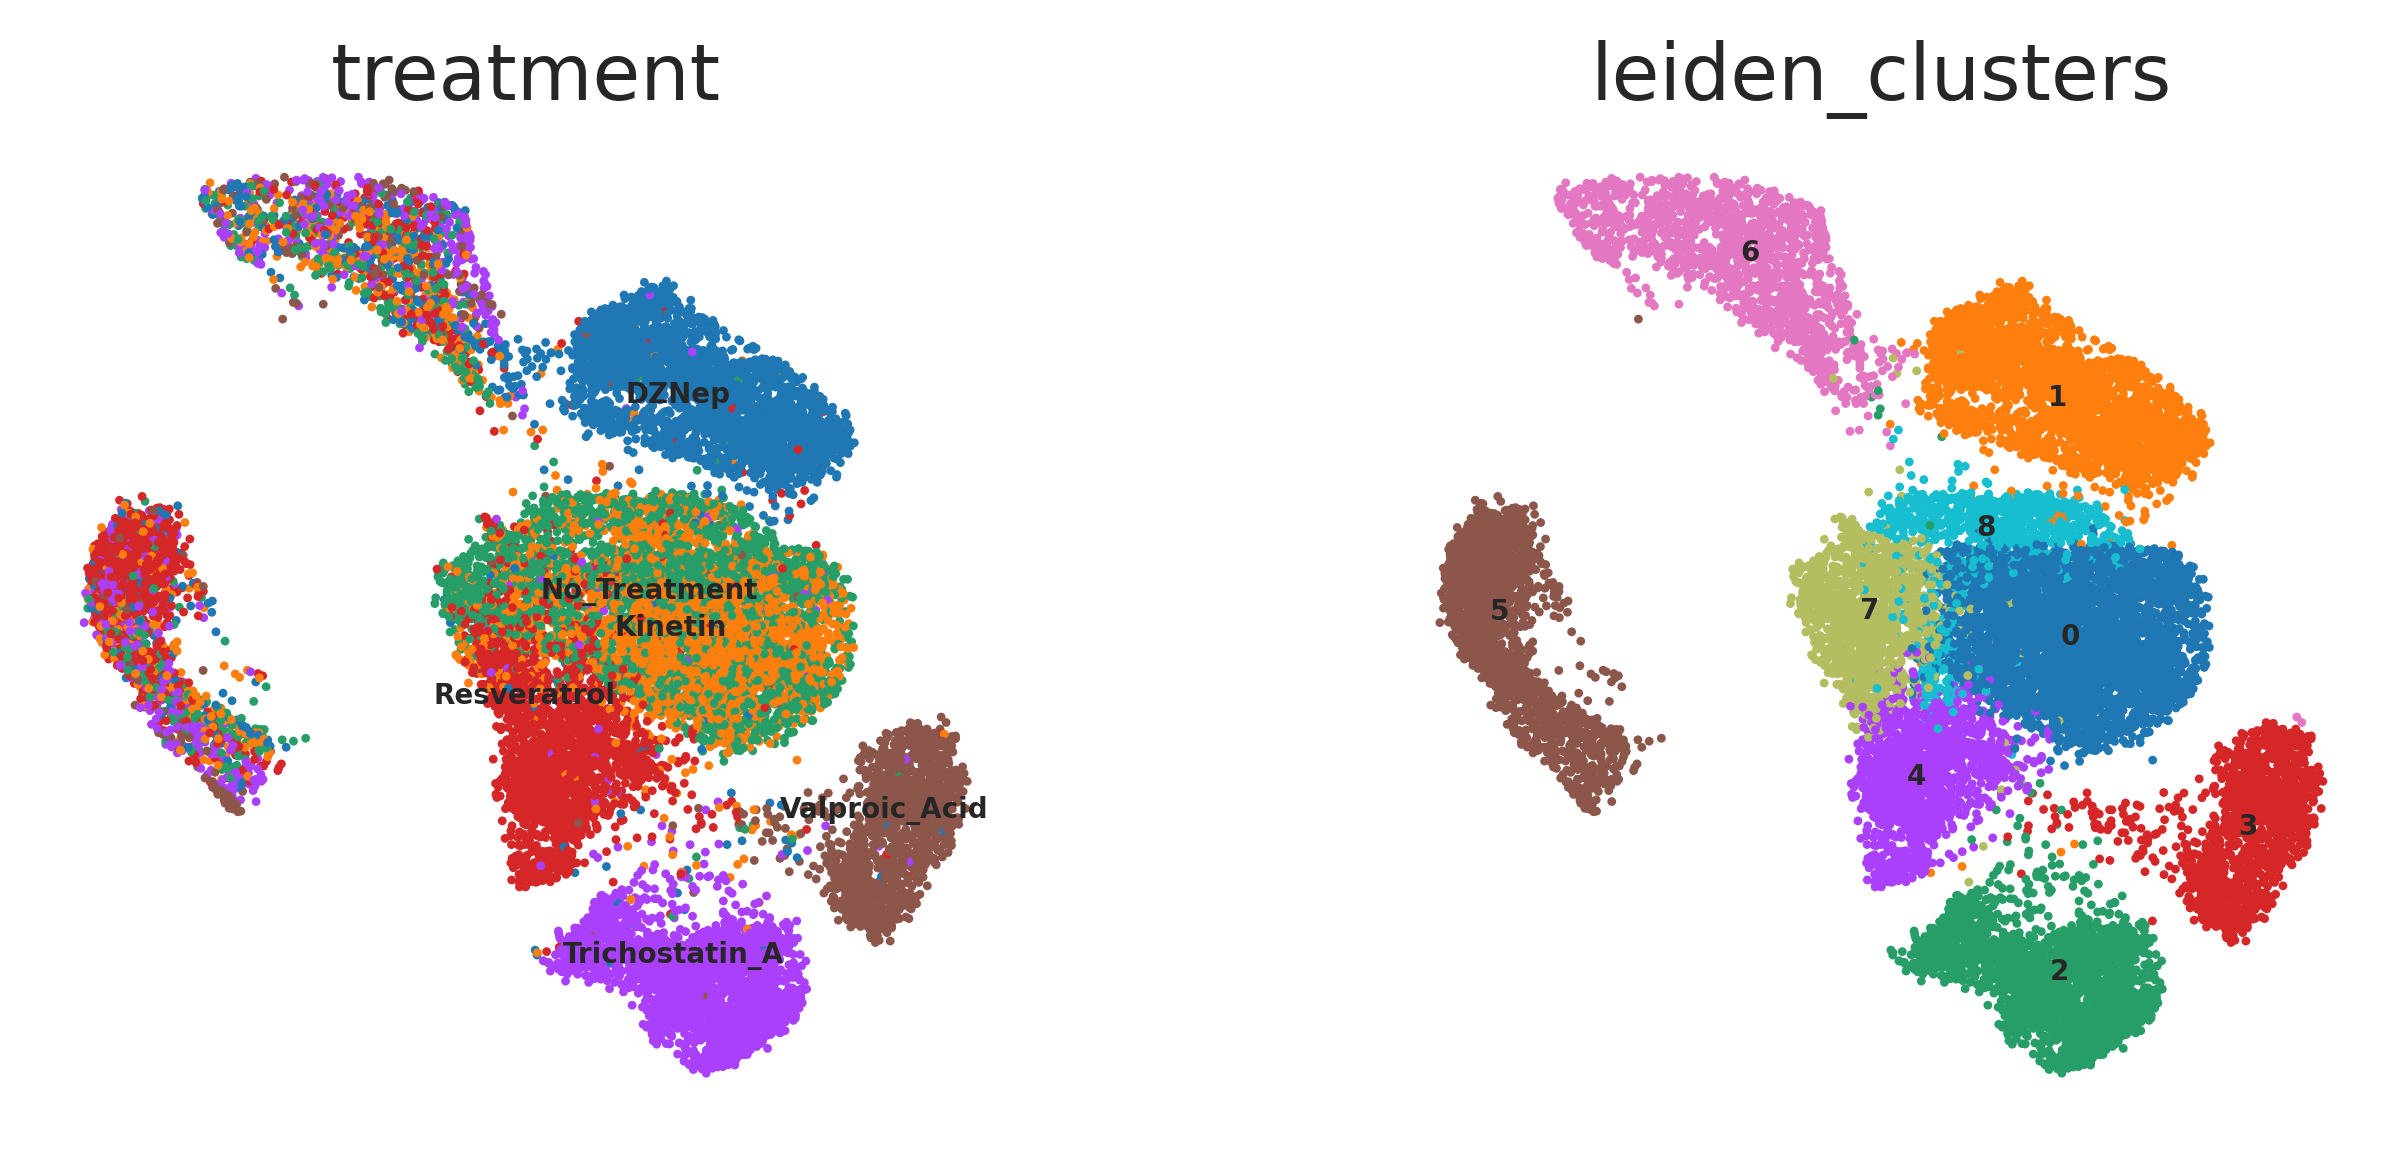

In [34]:
sc.settings.set_figure_params(dpi=200,figsize=(3, 3.2))
ax = sc.pl.umap(adata_out, size=10, color=["treatment", "leiden_clusters"],
                frameon=False,
                legend_loc="on data", legend_fontsize=5,
                vmax=3, vmin=0, return_fig=True)

Next, we can visulize the changes of cell fractions grouped by the perturbations upon treatment.

In [49]:
sgRNA_fraction = adata_out.obs.groupby(["treatment", "target_genes"]).count()["sgRNAs"]/adata_out.obs.groupby("treatment").count()["sgRNAs"]
sgRNA_fraction = sgRNA_fraction.to_frame("cell fraction").reset_index()
sgRNA_fraction.head()

,treatment,target_genes,cell fraction
0,DZNep,ACE2,0.042039
1,DZNep,ATF4,0.022509
2,DZNep,BAZ1B,0.018537
3,DZNep,BRD4,0.020192
4,DZNep,CAMLG,0.017875


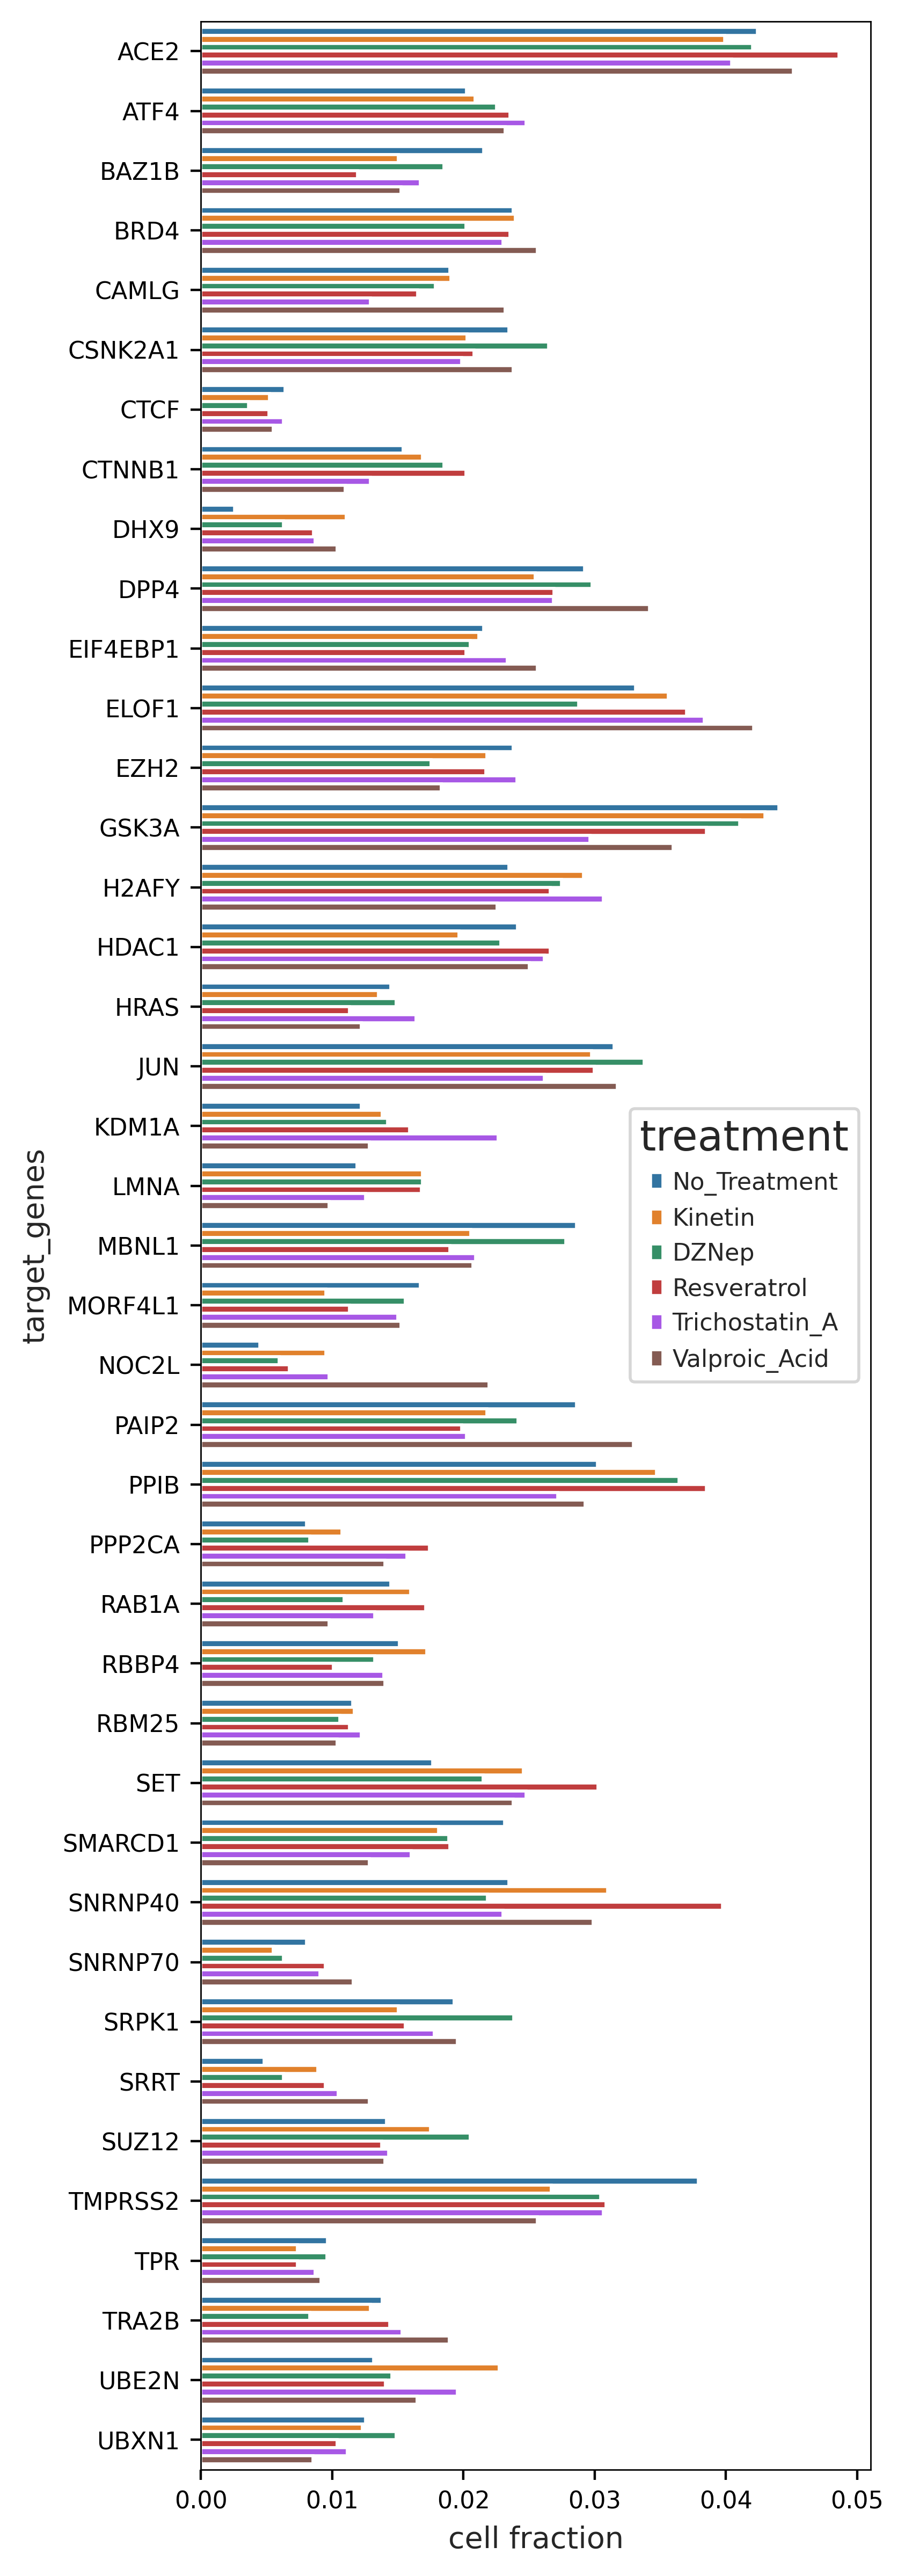

In [51]:
plt.figure(figsize=(4,15))
pylab.rcParams.update(params);

ax = sns.barplot(y="target_genes",
                 x="cell fraction",
                 hue="treatment",
                 hue_order=["No_Treatment", "Kinetin", "DZNep",  "Resveratrol", "Trichostatin_A", "Valproic_Acid"],
                 data=sgRNA_fraction)